# Autoencoder for Time series Syslog Log Anomaly Detection 

시간을 기준으로 한 Syslog 데이터를 이용하여 Autoencoder Anomaly Detection 진행.

---

## Simple EDA

In [1]:
# 파일 확인
!ls "./data"

HDFS_100k.log_anomaly_label.csv  LSTM_model_plot.png		  syslog.txt
HDFS_100k.log_structured.csv	 model_plot.png			  syslog.xls
LenMa_syslog.txt_structured.csv  SHISO_syslog.txt_structured.csv  weblog.csv
LenMa_syslog.txt_templates.csv	 SHISO_syslog.txt_templates.csv
log_model_HDFS.h5		 syslog.csv


In [2]:
# import section
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model, Sequential
from keras.layers import Dense, Input, LSTM ,Embedding , RepeatVector, TimeDistributed
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd

## Neural Netowork Autoencoder 
logparser의 LenMa 를 적용한 데이터

In [3]:
struct_log = './data/ha2.txt_structured.csv' # The structured log file

In [4]:
df = pd.read_csv(struct_log)

In [5]:
df.head()

,LineId,date,time,ip,Content,EventId,EventTemplate
0,1,2021-01-19,10:30:48,172.30.171.22,"BENIT_Client IP1 : 114.119.158.142, user_no : ...",73aa200a,"BENIT_Client <*> : <*>, user_no : session_id ..."
1,2,2021-01-19,10:30:48,172.30.171.22,"BENIT_Client IP2 : 114.119.158.142, user_no : ...",41de2f67,"BENIT_Client <*> : <*>, user_no : null, Header..."
2,3,2021-01-19,10:30:04,121.135.187.201,"BENIT_Client IP2 : 203.225.82.146, user_no : n...",c06227d3,"BENIT_Client <*> : <*>, user_no : null, Header..."
3,4,2021-01-19,10:30:04,121.135.187.201,"BENIT_Client IP2 : 203.225.82.146, user_no : n...",6d35b111,"BENIT_Client <*> : <*>, user_no : null, Header..."
4,5,2021-01-19,10:30:04,121.135.187.201,"BENIT_Client IP1 : 203.225.82.146, user_no : n...",73aa200a,"BENIT_Client <*> : <*>, user_no : session_id ..."


In [6]:
# simple EDA
df.isna().sum()

LineId           0
date             0
time             0
ip               0
Content          0
EventId          0
EventTemplate    0
dtype: int64

In [7]:
# simple EDA
for i in df.columns:
    print(i)
    print(df[i].unique())
    print(len(df[i].unique()))
    print(' === ')

on/13.0.4 Safari/605.1.15, Origin=https://dream.kolon.com, Connection=Keep-Alive, X-WebLogic-KeepAliveSecs=30, Accept-Language=ko-kr, Accept-Encoding=gzip, deflate, br, Referer=https://dream.kolon.com/RECRUIT_KOLON/hr/rec/recruit/jobapp/controller/candidate/JobApp020WebController/picturePopup.hr?jobopen_id=KLS202101130001&jobapp_company_id=KLS, X-Forwarded-For=<*>, X-WebLogic-Force-JVMID=-1363466462, Content-Type=multipart/form-data; boundary=----WebKitFormBoundarybTI04fx9tRrOoXqS, Accept=text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8}'
 'BENIT_Client <*> : <*>, user_no : visastocker@gmail.com_20210118225122, Header Info : {Cookie=SCOUTER=x1l65kpo12hfl1; _ga=GA1.2.2062165246.1610977819; _gat=1; _gid=GA1.2.1577602752.1610977819; JSESSIONID_RECRUIT=UgoVwnRhgbTMqfXpiJ1Wxc1JyaTIPgjMgFgcoFVDOuwtoBnJLxCw!-1363466462; SSCSID=MR11&&UgoVwnRhgbTMqfXpiJ1Wxc1JyaTIPgjMgFgcoFVDOuwtoBnJLxCw!-1363466462!1610977801313, Host=dream.kolon.com, X-Requested-With=XMLHttpRequest, Content-Leng

### Train

In [8]:
from utils import dataloader
from utils.preprocessing import Vectorizer_sys


batch_size = 32
hidden_size = 32
num_directions = 2
topk = 5
train_ratio = 0.2
window_size = 10
epoches = 2
num_workers = 2
device = 0 

x_, window_y_ = \
dataloader.load_sys(struct_log, window='session', window_size=window_size, train_ratio=train_ratio, split_type='uniform',Time =True)

====== Input data summary ======
Loading ./data/ha2.txt_structured.csv
Slicing 769 sessions, with window 10
Slicing done, 4191 windows generated
Train: windows


In [11]:
x_

,SessionId,EventSequence
0,0,"[296, 297, 298, 298, 299, 296, 296, 297, 298, 1]"
1,0,"[297, 298, 298, 299, 296, 296, 297, 298, 1, 327]"
2,1,"[1, 4, 3, 1, 311, 121, 1, 36, 1, 2]"
3,1,"[4, 3, 1, 311, 121, 1, 36, 1, 2, 1]"
4,1,"[3, 1, 311, 121, 1, 36, 1, 2, 1, 12]"
...,...,...
4186,767,"[1, 1, 7, 1, 8, 7, 1, 6, 1, 6]"
4187,767,"[1, 7, 1, 8, 7, 1, 6, 1, 6, 1]"
4188,767,"[7, 1, 8, 7, 1, 6, 1, 6, 1, 5]"
4189,767,"[1, 8, 7, 1, 6, 1, 6, 1, 5, 5]"


In [10]:
window_y_

0        327
1       #Pad
2          1
3         12
4          1
        ... 
4186       1
4187       5
4188       5
4189    #Pad
4190    #Pad
Name: Label, Length: 4191, dtype: object

In [12]:
feature_extractor = Vectorizer_sys()
train_dataset = feature_extractor.fit_transform(x_, window_y_)

In [13]:
train_dataset

{'SessionId': array([  0,   0,   1, ..., 767, 767, 768]),
 'window_y': array([ 2,  1,  4, ..., 61,  1,  1]),
 'x': array([[ 22,  23,  13, ...,  23,  13,   4],
        [ 23,  13,  13, ...,  13,   4,   2],
        [  4,  28,  29, ...,  43,   4,  15],
        ...,
        [140,   4,  10, ...,  69,   4,  61],
        [  4,  10, 140, ...,   4,  61,  61],
        [ 29,  28,   4, ...,   1,   1,   1]])}

In [14]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='./data/log_model_HDFS.h5'
    )
]

In [15]:
# NN Autoencoder model.
input_dim = train_dataset['x'].shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(input_dim//3*2, activation='relu')(input)
encode = Dense(input_dim//3, activation='relu')(encode)
encode = Dense(1, activation='relu')(encode)

decode = Dense(input_dim//3, activation='relu')(encode)
decode = Dense(input_dim//3*2, activation='relu')(decode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

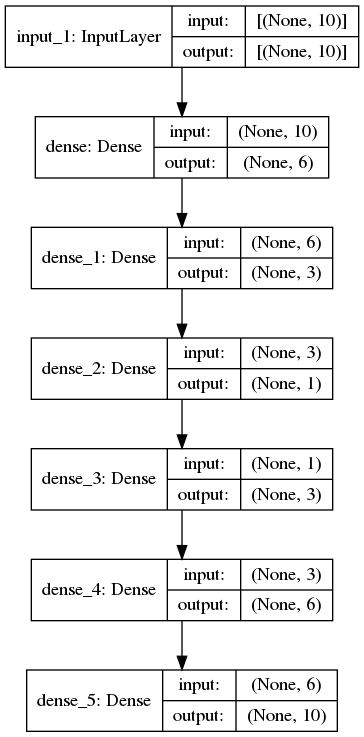

In [16]:
plot_model(autoencoder, to_file='./data/model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
# Create 6 layer model.
input_dim = train_dataset['x'].shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(input_dim//3*2, activation='relu')(input)
encode = Dense(input_dim//3, activation='relu')(encode)
encode = Dense(1, activation='relu')(encode)

decode = Dense(input_dim//3, activation='relu')(encode)
decode = Dense(input_dim//3*2, activation='relu')(decode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

# Train model.
history = autoencoder.fit(train_dataset['x'], train_dataset['x'],
        epochs=200,
        batch_size=128,
        callbacks=callbacks_list,
        shuffle=True
        )

 - 0s 811us/step - loss: 3734.9730 - accuracy: 0.1037
Epoch 12/200
33/33 [==============================] - 0s 625us/step - loss: 3798.3654 - accuracy: 0.1170
Epoch 13/200
33/33 [==============================] - 0s 765us/step - loss: 3693.6547 - accuracy: 0.1050
Epoch 14/200
33/33 [==============================] - 0s 660us/step - loss: 3813.0113 - accuracy: 0.1059
Epoch 15/200
33/33 [==============================] - 0s 775us/step - loss: 3738.7938 - accuracy: 0.1039
Epoch 16/200
33/33 [==============================] - 0s 805us/step - loss: 3620.0914 - accuracy: 0.1096
Epoch 17/200
33/33 [==============================] - 0s 706us/step - loss: 3734.1263 - accuracy: 0.1066
Epoch 18/200
33/33 [==============================] - 0s 785us/step - loss: 3597.3497 - accuracy: 0.1041
Epoch 19/200
33/33 [==============================] - 0s 605us/step - loss: 3713.7511 - accuracy: 0.0983
Epoch 20/200
33/33 [==============================] - 0s 724us/step - loss: 3731.1761 - accuracy: 0.0936
E

### Check the result

In [18]:
import pandas as pd

# Combined x and x_test.
new_x = train_dataset['x']

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quartile.
threshold = error_df.quantile(0.99)

error_df.describe()

,reconstruction_error
count,4191.000000
mean,3745.753977
std,5329.624840
min,15.401956
25%,558.950000
50%,1598.700000
75%,4621.300000
max,42521.200000


(array([3356.,  507.,  206.,   72.,   29.,   14.,    7.]),
 array([1.54019557e+01, 6.08765882e+03, 1.21599157e+04, 1.82321725e+04,
        2.43044294e+04, 3.03766863e+04, 3.64489431e+04, 4.25212000e+04]),
 <BarContainer object of 7 artists>)

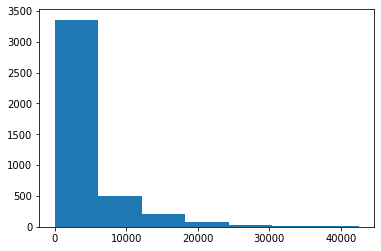

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

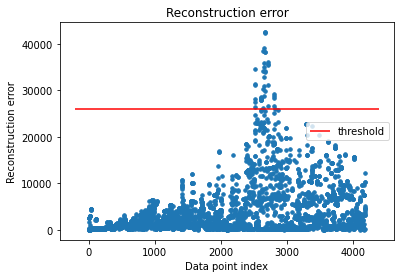

In [20]:
threshold = threshold

# Plot reconstruction error vs. the data.
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

output = []    
for x in index_list:
    output.append(new_x[x])


## LSTM Autoencoder

In [21]:
x = np.expand_dims(train_dataset['x'],axis=1)


In [22]:
# LSTM Autoencoder
model = Sequential()

# Encoder
model.add(LSTM(8, activation='relu', input_shape=(1,10), return_sequences=True))
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(1, activation='relu', return_sequences=True))
# model.add(RepeatVector(10))

# Decoder
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(8, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(10)))

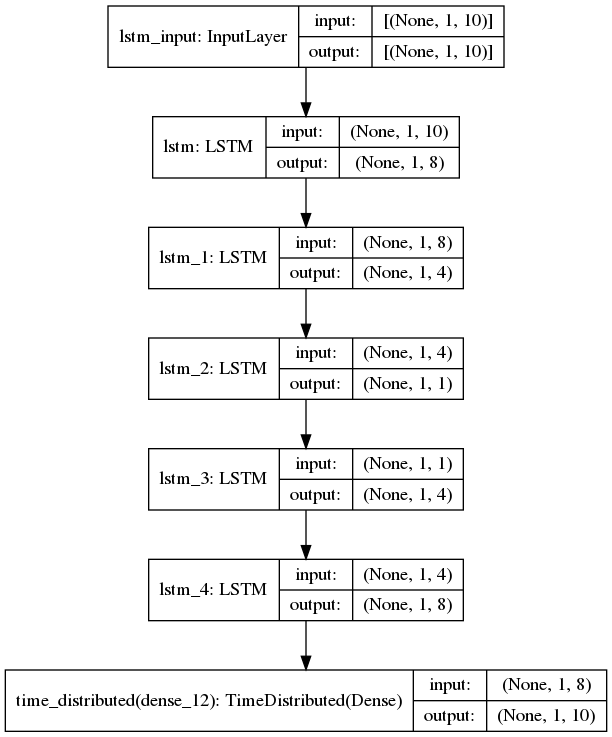

In [23]:
plot_model(model, to_file='./data/LSTM_model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

# fit
history = model.fit(x, x,
                     epochs=200, batch_size=128)

26 - accuracy: 0.0891
Epoch 8/200
33/33 [==============================] - 0s 3ms/step - loss: 2128.5517 - accuracy: 0.1215
Epoch 9/200
33/33 [==============================] - 0s 3ms/step - loss: 2088.4269 - accuracy: 0.1176
Epoch 10/200
33/33 [==============================] - 0s 3ms/step - loss: 2013.5903 - accuracy: 0.1167
Epoch 11/200
33/33 [==============================] - 0s 3ms/step - loss: 2055.0694 - accuracy: 0.1231
Epoch 12/200
33/33 [==============================] - 0s 3ms/step - loss: 2019.5590 - accuracy: 0.1281
Epoch 13/200
33/33 [==============================] - 0s 3ms/step - loss: 2072.4165 - accuracy: 0.1346
Epoch 14/200
33/33 [==============================] - 0s 3ms/step - loss: 1978.9659 - accuracy: 0.1300
Epoch 15/200
33/33 [==============================] - 0s 3ms/step - loss: 2031.5401 - accuracy: 0.1210
Epoch 16/200
33/33 [==============================] - 0s 3ms/step - loss: 2033.5247 - accuracy: 0.1276
Epoch 17/200
33/33 [==============================] -